# Modelling

The goal is to create model that will predict forex-pair value movements

### Plan: 

From the data:
1. Generate sentiment analysis using FinBERT model on a daily basis
2. `groupby()` the days and get the average sentiment 
3. Append the average daily sentiment and import over to another data `final_dataset`
4. `final_dataset` will have columns => `close_price`, `open_price`, `change_in_price`, `date`, `avg_news_sentiment` 
5. Use `Prophet` by Facebook first because its a sci-kit learn based model

Testing: 
1. Remove last week and try to predict this week's prices 

# Formatting for Modelling

1. Include sentiment analysis after retrieving data 
2. Change data to datetime 

EURUSD=X modelling

In [142]:
import pandas as pd
import numpy as np 
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import scipy

from prophet import Prophet

import yfinance as yf 

import tensorflow

### Database Cleaning & Formatting

In [143]:
articles = pd.read_parquet(r"../data/raw_scrapped_data/EURUSD=X_fxstreet_database")
# print(articles.columns) # DEBUG
# print(articles.describe) # DEBUG


In [144]:
# Init FinBERT
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

## Attach Ticker Values by the Publishing Date

*Optimize*

The thing about this function is that it averages throughout the whole hour. We could have done something similar to; 

If less than 30 mins the hour, get to the starting hour 
If more than 30 mins to the hour

Found to have lots of errors so I had to modify `find_ticker_val()` function to have a try and error catching. One of the errors were that on Weekends, stock market prices were not tracked thus no records. If `following_day` were to land on a Saturday, it would through an error.

Another is that days not within the market or have not been saved yet. Cases within days `2025-03-22` and onwards. We'll have to find a way: 

1. Safe keep the data (massive storage for all the articles) 
2. Find ticker values if possible
3. Remove NaNs 
4. Append to final modelling dataset. 

Then: 

1. For each article that is not in the final modelling dataset, try to find the `ticker_val` again. (Will incur compute costs though so we'll iterate through the lists) 
2. Append into final modelling dataset.

## Attach Ticker Values by the Daily Average 

1. Produce sentiment polarity value per article
2. Aggregate sentiment polarity by date 
3. Append daily high and low values (predict via range)
4. Calculate the daily difference! 

Test case: EURUSD

In [ ]:
# Load in raw article data 

# Load in finBERT AutoTokenizer & Classifier

Attach the sentiment! 

In [145]:
def analyze_sentiment(x):

    # Determine how BERT will analyze the text
    tokenizer_kwargs = {
    "padding" : True,
    "truncation" : True,
    "max_length" : 512,
    }

    with torch.no_grad():
        input_sequence = tokenizer(x, return_tensors="pt", **tokenizer_kwargs)
        logits = finbert(**input_sequence).logits
        # Apply softmax to get probabilities 
        prob = scipy.special.softmax(logits.numpy().squeeze())
        weights = {
            0 : -1, # Negative
            1 : 0, # Neutral
            2 : 1 # Positive
        }
        # Calculate polarity score
        polarity = sum(prob[i] * weights[i] for i in range(len(prob)))
    return polarity # Returns raw sentiment scores (as probabilities)

articles['sentiment_polarity'] = articles['text'].apply(analyze_sentiment)

# Ref: 
# https://www.kaggle.com/code/mexwell/huggingface-finbert-for-sentiment-analysis 2025-03-22
# https://medium.com/@ravirajshinde2000/financial-news-sentiment-analysis-using-finbert-25afcc95e65f 2025-03-22


Convert all the `date` rows into datetime objs

In [146]:
def convert_to_datetime(date_str):
    date_format = "%m/%d/%Y %H:%M:%S GMT"
    return datetime.strptime(date_str, date_format)

articles['date'] = articles['date'].apply(convert_to_datetime) # Override! 

Now, aggregate the sentiment polarity by date and average them! 

Then Add in daily high and low data. 

We should actually include other data that is available from yfinance and use them as additional regressors/ predictors to the model, perhaps it can give better accuracy? 

For improvements to the model AFTER the presentation, we'll be adding in 'Open' and 'Close' data!

In [147]:
EURUSD = yf.Ticker("EURUSD=X")

data = articles.copy()

print("--------------------------------------------")
print(f"The total na values: \n {data.isna().sum()}")
print("--------------------------------------------")

# Getting average daily news sentiment 

def get_params_val(start, end, ticker):
    ticker_data = ticker.history(start=start, end=end, interval="1d").reset_index()
    return float(ticker_data.loc[0,'High']), float(ticker_data.loc[0,'Low']), float(ticker_data.loc[0,'Open']), float(ticker_data.loc[0,'Close'])

# Function for finding daily ticker values; high and low 
# def find_params_val(day, ticker):
#     following_day = day + timedelta(days=1)
#     try:
#         return get_params_val(day, following_day, ticker)
#     except:
#         try: # For when posted on a Saturday, go one day back 
#             previous_day = day - timedelta(days=1)
#             return get_params_val(previous_day, day, ticker)
#         except: 
#             try: # For when posted on a sunday, go one day back 
#                 previous_2_days = day - timedelta(days=2)
#                 return get_params_val(previous_2_days, previous_day, ticker)
#             except:
#                 print(f"Error: for {day} and {following_day}")
#                 return None, None

# This version of find_params_val only appends `sentiment_polarity` to intra-day articles. Weekends are excluded
def find_params_val(day, ticker):
    following_day = day + timedelta(days=1)
    try:
        return get_params_val(day, following_day, ticker)
    except:
        print(f"Error: for {day} and {following_day}")
        return None, None, None, None

def format_articles_to_daily(articles, ticker): 
    # Get the aggregated daily sentiment
    daily_sentiment = articles[['date','sentiment_polarity']].groupby([articles['date'].dt.date]).mean('sentiment_polarity').reset_index()

    # Add in daily high and low data 
    daily_sentiment[['High','Low','Open','Close']] = pd.DataFrame(daily_sentiment['date'].apply(lambda day: find_params_val(day, ticker)).tolist(), index=daily_sentiment.index)

    print("--------------------------------------------")
    print(f"The number of null 'High' and 'Low' values found  \n {daily_sentiment.isnull().sum()}")
    print("--------------------------------------------")
    daily_sentiment.dropna(inplace=True)

    daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

    return daily_sentiment

data = format_articles_to_daily(data, EURUSD)
print(data.info())

--------------------------------------------
The total na values: 
 title                 0
link                  0
date                  0
text                  0
sentiment_polarity    0
dtype: int64
--------------------------------------------
Error: for 2025-02-23 and 2025-02-24
--------------------------------------------
The number of null 'High' and 'Low' values found  
 date                  0
sentiment_polarity    0
High                  1
Low                   1
Open                  1
Close                 1
dtype: int64
--------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 125 entries, 0 to 125
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                125 non-null    datetime64[ns]
 1   sentiment_polarity  125 non-null    float64       
 2   High                125 non-null    float64       
 3   Low                 125 non-null  

Limitations: 

We find that some articles are 'forecasting' like: Trump will place tarrifs, heres how the USD is impacted in the next couple days. But you can also have current market indicators: 'USD is like this because of Trump's tarrifs'. 

In [ ]:
data

,date,sentiment_polarity,High,Low,Open,Close
0,2024-10-09,0.775951,0.914094,0.910880,0.911153,0.911153
1,2024-10-10,0.681009,0.916280,0.913009,0.913968,0.913968
2,2024-10-11,0.514638,0.915156,0.912942,0.914629,0.914629
3,2024-10-14,0.693515,0.917019,0.914369,0.915508,0.915508
4,2024-10-15,0.746610,0.918687,0.916078,0.916708,0.916708
...,...,...,...,...,...,...
115,2025-03-25,0.616771,0.927807,0.923378,0.925686,0.925686
116,2025-03-26,0.769901,0.928712,0.925763,0.927042,0.927042
117,2025-03-27,0.527181,0.931029,0.924317,0.931012,0.931012
118,2025-03-28,0.546318,0.928867,0.922135,0.925892,0.925892


Analysis: Pearson Correlation of Lag

In [148]:
def get_lag_corr_of_vals(dataframe, param):
    values = pd.DataFrame(data[param].values)
    dataframe = pd.concat([values.shift(1), values], axis = 1)
    dataframe.columns = ['t-1', 't+1']
    result = dataframe.corr()
    print("-------------------------------------------------------------------------")
    print(f"The Pearson correlation coefficient for the lag of Daily '{param}' Difference Forex value is: \n{result}")

for param in ['High','Low','Open','Close','sentiment_polarity']:
    get_lag_corr_of_vals(data, param)


-------------------------------------------------------------------------
The Pearson correlation coefficient for the lag of Daily 'High' Difference Forex value is: 
         t-1      t+1
t-1  1.00000  0.70578
t+1  0.70578  1.00000
-------------------------------------------------------------------------
The Pearson correlation coefficient for the lag of Daily 'Low' Difference Forex value is: 
          t-1       t+1
t-1  1.000000  0.687956
t+1  0.687956  1.000000
-------------------------------------------------------------------------
The Pearson correlation coefficient for the lag of Daily 'Open' Difference Forex value is: 
          t-1       t+1
t-1  1.000000  0.698971
t+1  0.698971  1.000000
-------------------------------------------------------------------------
The Pearson correlation coefficient for the lag of Daily 'Close' Difference Forex value is: 
          t-1       t+1
t-1  1.000000  0.690106
t+1  0.690106  1.000000
------------------------------------------------------

So it seems like, the best way we can model it is through ticker values alone, but although using Ticker values themselves (for EURUSD) gives us 0.996379 Pearson Correlation Coeffficient, it's always statistically best to give predicted values within a range. Because we haven't been taught how to generate 95% confidence intervals for complex modelling techniques (apart from regression techniques taught in DATA 603) we'll opt to provide a forecast of `High` and `Low` -est values in the following day. 

This is also because we've aggregated our sentiment as per day - `yfinance` API does not provide an 'average daily value' for tickers, we are only given the highest and lowest value of a ticker in a given day. We are limited by the data we are provided with from our API

We should also look at the correlation of values between our predictors; Open, Close (for days thats have passed already, not available for current-day predictions) & sentiment_polarity, to our target; High and Low. 

In [149]:
def get_corr_of_pred_and_tar(dataframe, target):
    # dataframe = dataframe.drop(columns=exclusion)
    result = dataframe.corr()[target]
    print("---------------------------------------------------------------------------")
    print(f"The Pearson correlation coefficient for {target} against all : \n{result}")

for target in ['High','Low']:
    get_corr_of_pred_and_tar(data, target)

# Ref: 
# https://saturncloud.io/blog/how-to-calculate-pandas-correlation-of-one-column-against-all-others/

---------------------------------------------------------------------------
The Pearson correlation coefficient for High against all : 
date                  0.154386
sentiment_polarity    0.018916
High                  1.000000
Low                   0.990584
Open                  0.992337
Close                 0.992491
Name: High, dtype: float64
---------------------------------------------------------------------------
The Pearson correlation coefficient for Low against all : 
date                  0.126267
sentiment_polarity    0.026471
High                  0.990584
Low                   1.000000
Open                  0.990957
Close                 0.991067
Name: Low, dtype: float64


This gives us the answers to; which parameters should we consider? We should focus on using the data retrieved from yFinance instead of using sentiment_polarity! 

As for our test case right now: 

1. lag of `sentiment_polarity` = 0.042087
2. Pearson Corr of `sentiment_polarity` and `High` = -0.092077
3. Pearson Corr of `sentiment_polarity` and `Low` = -0.074192

For a total of: `|0.208356|`

We are just looking to see if we can actually make use of our web-scrapped articles data! 

-----

The current method makes it so that weekend-posted articles' sentiment polarities are aggregated to Friday (last most recent market-day). This is because Yahoo Finance only tracks the market value of days the market is open.

For when we remove weekend articles:
1. lag of `sentiment_polarity` = 0.07055
2. Pearson Corr of `sentiment_polarity` and `High` = -0.084655
3. Pearson Corr of `sentiment_polarity` and `Low` = -0.067640

For a total of: `|0.222845|`


-----

What if instead, we push the values forward as the articles foreshadow the events of the coming monday? 

for when we push weekend articles to the following Monday:
1. lag of `sentiment_polarity` = 0.042087
2. Pearson Corr of `sentiment_polarity` and `High` = -0.090461
3. Pearson Corr of `sentiment_polarity` and `Low` = -0.073865

For a total of: `|0.206413|`

*Conclusion* 

Through these test cases, although it's only within one time range, it's obvious we have the greatest correlation when we EXCLUDE the weekend articles! Fascinating? I don't know

We should also add other features now too! 

Simple Moving Average:

In [153]:
display(data.sort_values(by='date', ascending=True))

,date,sentiment_polarity,High,Low,Open,Close
0,2024-10-09,0.775951,0.914094,0.910880,0.911153,0.911153
1,2024-10-10,0.681009,0.916280,0.913009,0.913968,0.913968
2,2024-10-11,0.514638,0.915156,0.912942,0.914629,0.914629
3,2024-10-14,0.693515,0.917019,0.914369,0.915508,0.915508
4,2024-10-15,0.746610,0.918687,0.916078,0.916708,0.916708
...,...,...,...,...,...,...
121,2025-04-02,0.781711,0.927498,0.919760,0.926381,0.926381
122,2025-04-03,0.758440,0.919050,0.898457,0.917011,0.917011
123,2025-04-04,0.691375,0.912101,0.900406,0.905387,0.905551
124,2025-04-07,0.734600,0.917263,0.904986,0.910531,0.910531


In [ ]:
def calc_sma(df, target, window):
    return df[target].rolling(window=window).mean()

def get_sma_for_preds(dataframe, window, dropped_cols):
    for target in list(dataframe.drop(columns=dropped_cols).columns):
        col_name_sma = f'{target}_sma'
        dataframe[col_name_sma] = calc_sma(dataframe, target, window)
    return dataframe

data1 = data.copy()
data1 = get_sma_for_preds(data1.sort_values(by='date',ascending=False), 20, 'date')

# Ref: 
# https://gregorycernera.medium.com/computing-simple-moving-average-sma-with-python-pandas-yfinance-0458bb0b5d3b

In [ ]:
display(data1)

,date,sentiment_polarity,High,Low,Open,Close,sentiment_polarity_sma,High_sma,Low_sma,Open_sma,Close_sma
0,2024-10-09,0.775951,0.914094,0.910880,0.911153,0.911153,NaN,NaN,NaN,NaN,NaN
1,2024-10-10,0.681009,0.916280,0.913009,0.913968,0.913968,NaN,NaN,NaN,NaN,NaN
2,2024-10-11,0.514638,0.915156,0.912942,0.914629,0.914629,NaN,NaN,NaN,NaN,NaN
3,2024-10-14,0.693515,0.917019,0.914369,0.915508,0.915508,NaN,NaN,NaN,NaN,NaN
4,2024-10-15,0.746610,0.918687,0.916078,0.916708,0.916708,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
115,2025-03-25,0.616771,0.927807,0.923378,0.925686,0.925686,0.691195,0.933578,0.926861,0.930531,0.930531
116,2025-03-26,0.769901,0.928712,0.925763,0.927042,0.927042,0.691149,0.932284,0.925640,0.929355,0.929355
117,2025-03-27,0.527181,0.931029,0.924317,0.931012,0.931012,0.685119,0.930774,0.924179,0.928237,0.928237
118,2025-03-28,0.546318,0.928867,0.922135,0.925892,0.925892,0.674603,0.929055,0.922302,0.926427,0.926427


The issue now is that we're limited by the window size. 

Days remainder that didn't fit in the window size have `NaN` values for their sma.... so let's grab the average moving average of the remaining. 

In [ ]:
# Select rows that have na values 

null_mask = data1.isnull().any(axis=1)
null_rows = data1[null_mask]
null_rows = null_rows.dropna(axis=1)
null_rows

# We'll fill it to be a 5 day moving average for the average per work week (try to)
null_rows = get_sma_for_preds(null_rows, 5, 'date')

null_rows


,date,sentiment_polarity,High,Low,Open,Close,sentiment_polarity_sma,High_sma,Low_sma,Open_sma,Close_sma
0,2024-10-09,0.775951,0.914094,0.910880,0.911153,0.911153,NaN,NaN,NaN,NaN,NaN
1,2024-10-10,0.681009,0.916280,0.913009,0.913968,0.913968,NaN,NaN,NaN,NaN,NaN
2,2024-10-11,0.514638,0.915156,0.912942,0.914629,0.914629,NaN,NaN,NaN,NaN,NaN
3,2024-10-14,0.693515,0.917019,0.914369,0.915508,0.915508,NaN,NaN,NaN,NaN,NaN
4,2024-10-15,0.746610,0.918687,0.916078,0.916708,0.916708,0.682344,0.916247,0.913455,0.914393,0.914393
5,2024-10-16,0.582101,0.920133,0.917372,0.918814,0.918814,0.643575,0.917455,0.914754,0.915925,0.915925
6,2024-10-17,0.712921,0.924907,0.920209,0.920955,0.920955,0.649957,0.919180,0.916194,0.917322,0.917322
7,2024-10-18,0.663025,0.923702,0.920539,0.923480,0.923480,0.679634,0.920889,0.917714,0.919093,0.919093
8,2024-10-21,0.730683,0.924300,0.920107,0.920141,0.920141,0.687068,0.922346,0.918861,0.920019,0.920019
9,2024-10-22,0.609528,0.925797,0.922722,0.924625,0.924625,0.659652,0.923768,0.920190,0.921603,0.921603


In [ ]:
# Now append this to our final dataset 
data1[null_mask] = null_rows[null_mask]

data1.dropna(inplace=True)


C:\Users\sumag\AppData\Local\Temp\ipykernel_6704\2848656522.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  articles2[null_mask] = null_rows[null_mask]


Now to asses! 

In [ ]:
def get_corr_of_pred_and_tar(dataframe, target):
    # dataframe = dataframe.drop(columns=exclusion)
    result = dataframe.corr()[target]
    print("---------------------------------------------------------------------------")
    print(f"The Pearson correlation coefficient for {target} against all : \n{result}")

for target in ['High','Low']:
    get_corr_of_pred_and_tar(data1, target)

# Ref: 
# https://saturncloud.io/blog/how-to-calculate-pandas-correlation-of-one-column-against-all-others/

---------------------------------------------------------------------------
The Pearson correlation coefficient for High against all : 
date                      0.108109
sentiment_polarity        0.058987
High                      1.000000
Low                       0.987401
Open                      0.986952
Close                     0.986961
sentiment_polarity_sma    0.247182
High_sma                  0.778091
Low_sma                   0.774367
Open_sma                  0.760567
Close_sma                 0.760582
Name: High, dtype: float64
---------------------------------------------------------------------------
The Pearson correlation coefficient for Low against all : 
date                      0.100796
sentiment_polarity        0.081123
High                      0.987401
Low                       1.000000
Open                      0.987669
Close                     0.987678
sentiment_polarity_sma    0.243221
High_sma                  0.779519
Low_sma                   0.777702
Op

We'll save this dataset to be modelled now! 

And just to check the fit of the data, lets run OLS Regression.

`High` correlation with other data

In [ ]:
import pandas as pd
import statsmodels.formula.api as sm
result = sm.ols(formula="High ~ sentiment_polarity + Open + Close + sentiment_polarity_sma + High_sma + Low_sma	+ Open_sma + Close_sma", data=data1).fit()
print(result.params)
print(result.summary())

# Ref: 
# https://stackoverflow.com/questions/19991445/run-an-ols-regression-with-pandas-data-frame

Intercept                   0.004111
sentiment_polarity         -0.002877
Open                      -17.049263
Close                      17.981852
sentiment_polarity_sma      0.019109
High_sma                    1.511537
Low_sma                     1.251182
Open_sma                  125.622495
Close_sma                -128.331345
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   High   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     579.5
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           8.52e-84
Time:                        21:49:36   Log-Likelihood:                 514.95
No. Observations:                 115   AIC:                            -1012.
Df Residuals:                     106   BIC:                            -987.2
Df Model:           

Low correlation with other data

In [ ]:
result = sm.ols(formula="Low ~ sentiment_polarity + Open + Close + sentiment_polarity_sma + High_sma + Low_sma	+ Open_sma + Close_sma", data=data1).fit()
print(result.params)
print(result.summary())

# Ref: 
# https://stackoverflow.com/questions/19991445/run-an-ols-regression-with-pandas-data-frame

Intercept                   0.010658
sentiment_polarity          0.001599
Open                      -22.566623
Close                      23.484464
sentiment_polarity_sma      0.025775
High_sma                    0.610194
Low_sma                     1.581789
Open_sma                 -255.934168
Close_sma                 253.792727
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    Low   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     600.3
Date:                Mon, 07 Apr 2025   Prob (F-statistic):           1.36e-84
Time:                        21:49:36   Log-Likelihood:                 520.55
No. Observations:                 115   AIC:                            -1023.
Df Residuals:                     106   BIC:                            -998.4
Df Model:           

In [ ]:
data1.to_parquet("../data/modelling_dataset/EURUSD=X_modelling_dataset")

## Modelling

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 

import os 
from datetime import datetime

import plotly.express as px
from plotly.subplots import make_subplots

Using this tutorial: https://youtu.be/94PlBzgeq90?si=rhcKPOj8b7IyCx7a, to build the model

In [2]:
data = pd.read_parquet("../data/modelling_dataset/EURUSD=X_modelling_dataset");
print(data.isnull().sum())
print(f"Number of days: {len(data)}")
print(data.info())
# print(data.describe())

date                      0
sentiment_polarity        0
High                      0
Low                       0
Open                      0
Close                     0
sentiment_polarity_sma    0
High_sma                  0
Low_sma                   0
Open_sma                  0
Close_sma                 0
dtype: int64
Number of days: 115
<class 'pandas.core.frame.DataFrame'>
Index: 115 entries, 4 to 119
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    115 non-null    datetime64[ns]
 1   sentiment_polarity      115 non-null    float64       
 2   High                    115 non-null    float64       
 3   Low                     115 non-null    float64       
 4   Open                    115 non-null    float64       
 5   Close                   115 non-null    float64       
 6   sentiment_polarity_sma  115 non-null    float64       
 7   High_sma      

In [3]:
data.head()

,date,sentiment_polarity,High,Low,Open,Close,sentiment_polarity_sma,High_sma,Low_sma,Open_sma,Close_sma
4,2024-10-15,0.746610,1.091822,1.088578,1.090917,1.090917,0.682344,1.094944,1.091473,1.093749,1.093749
5,2024-10-16,0.582101,1.090156,1.086815,1.088412,1.088412,0.643575,1.093364,1.090022,1.091917,1.091917
6,2024-10-17,0.712921,1.086992,1.081385,1.086248,1.086248,0.649957,1.091673,1.088018,1.090300,1.090300
7,2024-10-18,0.663025,1.086366,1.082825,1.082954,1.082954,0.679634,1.089862,1.086035,1.088214,1.088214
8,2024-10-21,0.730683,1.086957,1.082111,1.086862,1.086862,0.687068,1.088459,1.084343,1.087079,1.087079


Our target variables will be 'Low' and 'High' respectively! 

<Axes: xlabel='date', ylabel='High'>

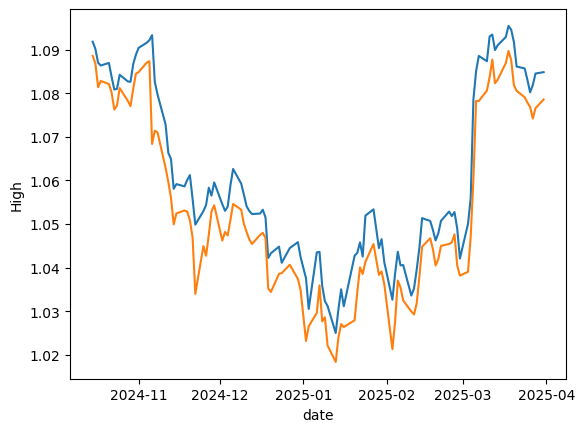

In [6]:
sns.lineplot(
    x='date',
    y='High',
    data=data)

sns.lineplot(
    x='date',
    y='Low',
    data=data,
)

Aggregate the data per Day 

# Modelling Using Prophet

In [154]:
import pandas as pd 
from prophet import Prophet

We have to rename the columns to be acceptable within `Prophet` format. We need `dates` to be `ds` & `ticker_val` to be `y`

In this manner; we'll predict two-fold, we'll predict over our predictors, then the ticker's `High` and `Low`

18:20:46 - cmdstanpy - INFO - Chain [1] start processing
18:20:46 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2025-03-20,0.916621,0.908764,0.924328
1,2025-03-21,0.914765,0.906702,0.922078
2,2025-03-22,0.910797,0.902767,0.918142
3,2025-03-23,0.909246,0.901435,0.916754
4,2025-03-24,0.910631,0.903051,0.917924
5,2025-03-25,0.908559,0.900437,0.916212
6,2025-03-26,0.906830,0.899111,0.914457
7,2025-03-27,0.905765,0.897658,0.913329


,date,sentiment_polarity,High,Low,Open,Close,sentiment_polarity_sma,High_sma,Low_sma,Open_sma,Close_sma
112,2025-03-20,0.741522,0.924411,0.915994,0.916590,0.916590,0.685055,0.938068,0.931219,0.935201,0.935201
113,2025-03-21,0.716170,0.925549,0.920887,0.921141,0.921141,0.688121,0.936493,0.929665,0.933638,0.933638
114,2025-03-24,0.789688,0.926784,0.921141,0.922961,0.922961,0.697670,0.935002,0.928231,0.932047,0.932047
115,2025-03-25,0.616771,0.927807,0.923378,0.925686,0.925686,0.691195,0.933578,0.926861,0.930531,0.930531
116,2025-03-26,0.769901,0.928712,0.925763,0.927042,0.927042,0.691149,0.932284,0.925640,0.929355,0.929355
117,2025-03-27,0.527181,0.931029,0.924317,0.931012,0.931012,0.685119,0.930774,0.924179,0.928237,0.928237
118,2025-03-28,0.546318,0.928867,0.922135,0.925892,0.925892,0.674603,0.929055,0.922302,0.926427,0.926427
119,2025-03-31,0.746794,0.927205,0.921837,0.923933,0.923933,0.684271,0.927291,0.920774,0.924605,0.924605
120,2025-04-01,0.714395,0.927730,0.923361,0.924385,0.924385,0.687049,0.925926,0.919589,0.923132,0.923132
121,2025-04-02,0.781711,0.927498,0.919760,0.926381,0.926381,0.696653,0.925143,0.919217,0.922388,0.922388


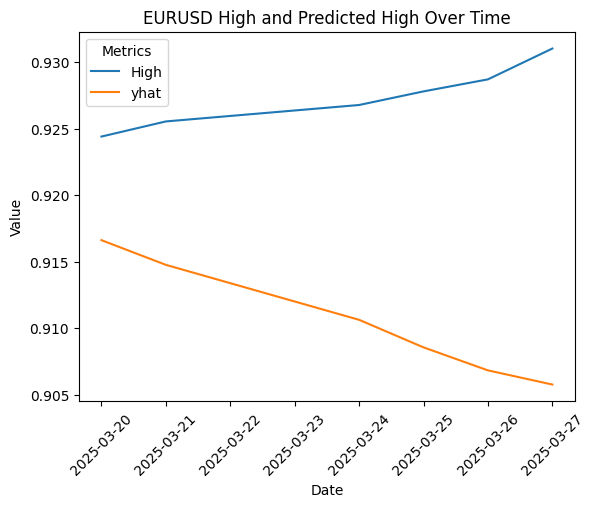

The RMSE is: 0.1338440225279076


In [155]:
from datetime import timedelta

data = pd.read_parquet("../data/modelling_dataset/EURUSD=X_modelling_dataset");

# We'll make a psuedo train-test split 

target = 'High' # Set this as function input

cutoff_date = datetime(month=3, day=20, year=2025)

train = data[data['date'] < cutoff_date]
test = data[data['date'] >= cutoff_date]

sentiment_df = train[['date','High']].rename(mapper = {"date" : "ds", target : "y"}, axis = 1)

m = Prophet()
m.fit(sentiment_df)

# # For on the data future use-case
# future = m.make_future_dataframe(periods=5)
# future.tail()

# Since we're testing with current data: 
future = pd.DataFrame({"ds" : [cutoff_date + timedelta(days= i) for i in range(0,8)]})
future.head()

forecast = m.predict(future)
display(forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])
display(test)

from sklearn.metrics import root_mean_squared_error

# Join the tables together
merged = pd.merge(test, forecast[['ds','yhat']], how='inner', left_on='date', right_on='ds').drop(columns=['ds'])

# Reshape the DataFrame to a long format for easy plotting with seaborn
plot_data = merged.melt(id_vars=['date'], value_vars=[target, 'yhat'], 
                        var_name='Metric', value_name='Value')

# Plot using seaborn
sns.lineplot(
    data=plot_data,
    x="date",
    y="Value",
    hue="Metric"  # Different colors for 'sentiment_polarity' and 'yhat'
)

# Optional: Add labels and a title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("EURUSD High and Predicted High Over Time")
plt.legend(title="Metrics")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

rmse = np.sqrt(root_mean_squared_error(merged['yhat'], merged[target]))
print(f"The RMSE is: {rmse}")

With `sentiment_polarity` as an additional regressor

18:22:09 - cmdstanpy - INFO - Chain [1] start processing
18:22:09 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
0,2025-03-20,0.688134,0.583779,0.791441
1,2025-03-21,0.718674,0.623360,0.823358
2,2025-03-22,0.763136,0.660044,0.865507
3,2025-03-23,0.763461,0.665436,0.865411
4,2025-03-24,0.716442,0.603169,0.813399
5,2025-03-25,0.728592,0.625294,0.839078
6,2025-03-26,0.722554,0.620862,0.819623
7,2025-03-27,0.690411,0.588085,0.792820


,date,sentiment_polarity,High,Low,Open,Close,sentiment_polarity_sma,High_sma,Low_sma,Open_sma,Close_sma
112,2025-03-20,0.741522,0.924411,0.915994,0.916590,0.916590,0.685055,0.938068,0.931219,0.935201,0.935201
113,2025-03-21,0.716170,0.925549,0.920887,0.921141,0.921141,0.688121,0.936493,0.929665,0.933638,0.933638
114,2025-03-24,0.789688,0.926784,0.921141,0.922961,0.922961,0.697670,0.935002,0.928231,0.932047,0.932047
115,2025-03-25,0.616771,0.927807,0.923378,0.925686,0.925686,0.691195,0.933578,0.926861,0.930531,0.930531
116,2025-03-26,0.769901,0.928712,0.925763,0.927042,0.927042,0.691149,0.932284,0.925640,0.929355,0.929355
117,2025-03-27,0.527181,0.931029,0.924317,0.931012,0.931012,0.685119,0.930774,0.924179,0.928237,0.928237
118,2025-03-28,0.546318,0.928867,0.922135,0.925892,0.925892,0.674603,0.929055,0.922302,0.926427,0.926427
119,2025-03-31,0.746794,0.927205,0.921837,0.923933,0.923933,0.684271,0.927291,0.920774,0.924605,0.924605
120,2025-04-01,0.714395,0.927730,0.923361,0.924385,0.924385,0.687049,0.925926,0.919589,0.923132,0.923132
121,2025-04-02,0.781711,0.927498,0.919760,0.926381,0.926381,0.696653,0.925143,0.919217,0.922388,0.922388


18:22:09 - cmdstanpy - INFO - Chain [1] start processing
18:22:09 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,sentiment_polarity
0,2025-03-20,0.916042,0.908396,0.923613,-0.000005
1,2025-03-21,0.914197,0.906611,0.921547,-0.000516
2,2025-03-22,0.909519,0.902414,0.916452,-0.001259
3,2025-03-23,0.907947,0.900368,0.914958,-0.001264
4,2025-03-24,0.909994,0.902635,0.917634,-0.000478
5,2025-03-25,0.907915,0.900344,0.915662,-0.000681
6,2025-03-26,0.906161,0.898952,0.913873,-0.000580
7,2025-03-27,0.905041,0.897334,0.912465,-0.000043


,date,sentiment_polarity,High,Low,Open,Close,sentiment_polarity_sma,High_sma,Low_sma,Open_sma,Close_sma
4,2024-10-15,0.746610,0.918687,0.916078,0.916708,0.916708,0.682344,0.916247,0.913455,0.914393,0.914393
5,2024-10-16,0.582101,0.920133,0.917372,0.918814,0.918814,0.643575,0.917455,0.914754,0.915925,0.915925
6,2024-10-17,0.712921,0.924907,0.920209,0.920955,0.920955,0.649957,0.919180,0.916194,0.917322,0.917322
7,2024-10-18,0.663025,0.923702,0.920539,0.923480,0.923480,0.679634,0.920889,0.917714,0.919093,0.919093
8,2024-10-21,0.730683,0.924300,0.920107,0.920141,0.920141,0.687068,0.922346,0.918861,0.920019,0.920019
...,...,...,...,...,...,...,...,...,...,...,...
107,2025-03-13,0.663937,0.923992,0.917667,0.918687,0.918687,0.697585,0.947373,0.940859,0.944846,0.944846
108,2025-03-14,0.694430,0.923267,0.916607,0.921302,0.921302,0.690960,0.945679,0.939131,0.943111,0.943111
109,2025-03-17,0.699692,0.920099,0.914997,0.919101,0.919101,0.685278,0.943913,0.937288,0.941396,0.941396
110,2025-03-18,0.791181,0.917751,0.912942,0.915927,0.915927,0.684967,0.941918,0.935252,0.939500,0.939500


,date,sentiment_polarity,High,Low,Open,Close,sentiment_polarity_sma,High_sma,Low_sma,Open_sma,Close_sma,yhat
0,2025-03-20,0.741522,0.924411,0.915994,0.916590,0.916590,0.685055,0.938068,0.931219,0.935201,0.935201,0.916042
1,2025-03-21,0.716170,0.925549,0.920887,0.921141,0.921141,0.688121,0.936493,0.929665,0.933638,0.933638,0.914197
2,2025-03-24,0.789688,0.926784,0.921141,0.922961,0.922961,0.697670,0.935002,0.928231,0.932047,0.932047,0.909994
3,2025-03-25,0.616771,0.927807,0.923378,0.925686,0.925686,0.691195,0.933578,0.926861,0.930531,0.930531,0.907915
4,2025-03-26,0.769901,0.928712,0.925763,0.927042,0.927042,0.691149,0.932284,0.925640,0.929355,0.929355,0.906161
5,2025-03-27,0.527181,0.931029,0.924317,0.931012,0.931012,0.685119,0.930774,0.924179,0.928237,0.928237,0.905041


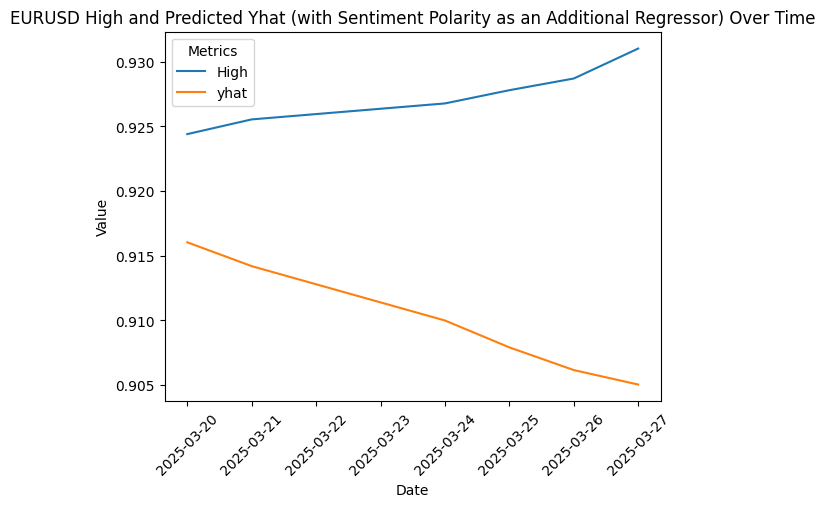

The RMSE is: 0.1361300382721661


In [156]:
from datetime import timedelta

data = pd.read_parquet("../data/modelling_dataset/EURUSD=X_modelling_dataset");

# We'll make a psuedo train-test split 

target = 'High' # Set this as function input

cutoff_date = datetime(month=3, day=20, year=2025)

train = data[data['date'] < cutoff_date]
test = data[data['date'] >= cutoff_date]


# --- Sentiment Polarity forecasting first ---

sentiment_df = train[['date','sentiment_polarity']].rename(mapper = {"date" : "ds", "sentiment_polarity" : "y"}, axis = 1)

m = Prophet()
m.fit(sentiment_df)

# # For on the data future use-case
# future = m.make_future_dataframe(periods=5)
# future.tail()

# Since we're testing with current data: 
future = pd.DataFrame({"ds" : [cutoff_date + timedelta(days= i) for i in range(0,8)]})
future.head()

forecast = m.predict(future)
display(forecast[['ds','yhat', 'yhat_lower', 'yhat_upper']])
display(test)

sentiment_regressor = forecast['yhat']

# --- Forecasting the target variable ---

sentiment_df = train[['date','High','sentiment_polarity']].rename(mapper = {"date" : "ds", target : "y"}, axis = 1)

m = Prophet()
m.add_regressor('sentiment_polarity')
m.fit(sentiment_df)

# # For on the data future use-case
# future = m.make_future_dataframe(periods=5)
# future.tail()

# Since we're testing with current data: 
future = pd.DataFrame({"ds" : [cutoff_date + timedelta(days= i) for i in range(0,8)], "sentiment_polarity" : sentiment_regressor})

forecast = m.predict(future)
display(forecast[['ds','yhat', 'yhat_lower', 'yhat_upper', 'sentiment_polarity']])
display(train)

from sklearn.metrics import mean_squared_error

# Join the tables together
merged = pd.merge(test, forecast[['ds','yhat']], how='inner', left_on='date', right_on='ds').drop(columns=['ds'])
display(merged)

# Reshape the DataFrame to a long format for easy plotting with seaborn
plot_data = merged.melt(id_vars=['date'], value_vars=[target, 'yhat'], 
                        var_name='Metric', value_name='Value')

# Plot using seaborn
sns.lineplot(
    data=plot_data,
    x="date",
    y="Value",
    hue="Metric"  # Different colors for 'sentiment_polarity' and 'yhat'
)

# Optional: Add labels and a title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("EURUSD High and Predicted Yhat (with Sentiment Polarity as an Additional Regressor) Over Time")
plt.legend(title="Metrics")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

rmse = np.sqrt(root_mean_squared_error(merged['yhat'], merged[target]))
print(f"The RMSE is: {rmse}")

For when all predictors are included! 

In [224]:
for drop_columns in [[],['sentiment_polarity','sentiment_polarity_sma',]]:
    print(drop_columns)

[]
['sentiment_polarity', 'sentiment_polarity_sma']


20:10:08 - cmdstanpy - INFO - Chain [1] start processing
20:10:08 - cmdstanpy - INFO - Chain [1] done processing
20:10:08 - cmdstanpy - INFO - Chain [1] start processing
20:10:08 - cmdstanpy - INFO - Chain [1] done processing
20:10:08 - cmdstanpy - INFO - Chain [1] start processing
20:10:08 - cmdstanpy - INFO - Chain [1] done processing
20:10:08 - cmdstanpy - INFO - Chain [1] start processing
20:10:08 - cmdstanpy - INFO - Chain [1] done processing
20:10:08 - cmdstanpy - INFO - Chain [1] start processing
20:10:08 - cmdstanpy - INFO - Chain [1] done processing
20:10:08 - cmdstanpy - INFO - Chain [1] start processing
20:10:09 - cmdstanpy - INFO - Chain [1] done processing


,ds,Open,Close,High_sma,Low_sma,Open_sma,Close_sma
0,2025-03-20,0.914317,0.914244,0.944101,0.937657,0.941703,0.941698
1,2025-03-21,0.912890,0.912817,0.943311,0.936826,0.940927,0.940921
2,2025-03-22,0.908571,0.908360,0.940345,0.933868,0.937906,0.937902
3,2025-03-23,0.907040,0.906827,0.939543,0.933060,0.937116,0.937111
4,2025-03-24,0.908851,0.908774,0.940576,0.934071,0.938248,0.938240
5,2025-03-25,0.906780,0.906694,0.939784,0.933315,0.937429,0.937420
6,2025-03-26,0.903595,0.903501,0.938993,0.932492,0.936654,0.936647
7,2025-03-27,0.903604,0.903509,0.938486,0.932001,0.936171,0.936162


20:10:09 - cmdstanpy - INFO - Chain [1] start processing
20:10:09 - cmdstanpy - INFO - Chain [1] done processing


,date,High,Low,Open,Close,High_sma,Low_sma,Open_sma,Close_sma,yhat
0,2025-03-20,0.924411,0.915994,0.916590,0.916590,0.938068,0.931219,0.935201,0.935201,0.916631
1,2025-03-21,0.925549,0.920887,0.921141,0.921141,0.936493,0.929665,0.933638,0.933638,0.914770
2,2025-03-24,0.926784,0.921141,0.922961,0.922961,0.935002,0.928231,0.932047,0.932047,0.910700
3,2025-03-25,0.927807,0.923378,0.925686,0.925686,0.933578,0.926861,0.930531,0.930531,0.908612
4,2025-03-26,0.928712,0.925763,0.927042,0.927042,0.932284,0.925640,0.929355,0.929355,0.906963
5,2025-03-27,0.931029,0.924317,0.931012,0.931012,0.930774,0.924179,0.928237,0.928237,0.905803


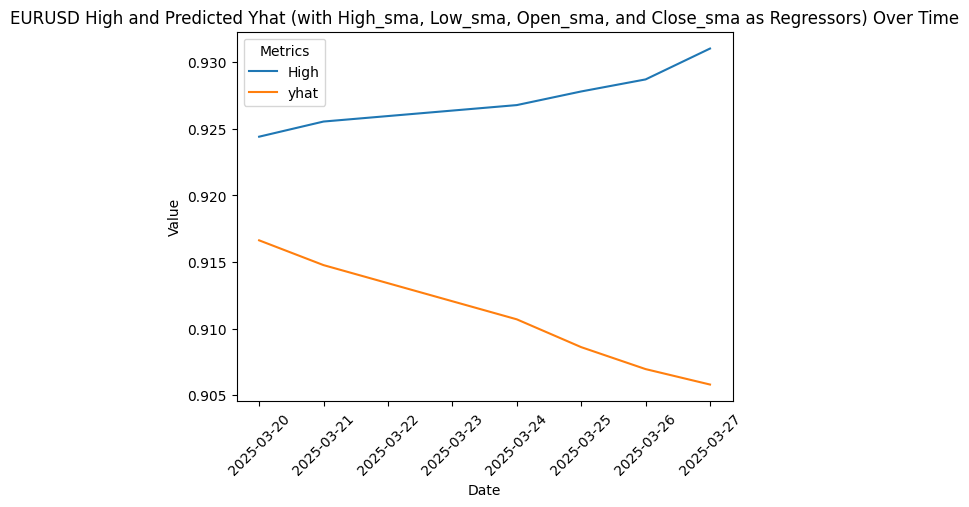

The RMSE is: 0.13363061582894326


In [223]:
from datetime import timedelta

data = pd.read_parquet("../data/modelling_dataset/EURUSD=X_modelling_dataset");

# Toggle this on if you want the most accurate model!
data = data.drop(columns=['sentiment_polarity','sentiment_polarity_sma',])

# We'll make a psuedo train-test split 

target = 'High' # Set this as function input

cutoff_date = datetime(month=3, day=20, year=2025)

train = data[data['date'] < cutoff_date]
test = data[data['date'] >= cutoff_date]


# --- Forecast each predictor first ---

def generate_future_predictors_prophet(train, range_end): 
    forecasts = {}
    for predictor in train.drop(columns=['date','High','Low']).columns:
        # Prep the data to fit prophet's requirements
        df_fit = train[['date',predictor]].rename(mapper = {"date" : "ds", predictor : "y"}, axis = 1)

        # Init the model 
        m = Prophet()
        m.fit(df_fit)

        # 1. Generate future df to store forecast
        future = pd.DataFrame({"ds" : [cutoff_date + timedelta(days= i) for i in range(0,range_end)]})
        # 2. Forecast
        forecast = m.predict(future)

        if 'ds' not in list(forecasts.keys()): 
            forecasts['ds'] = forecast['ds']

        forecasts[predictor] = forecast['yhat']

    forecasts = pd.DataFrame(forecasts)
    return forecasts

future_predictors = generate_future_predictors_prophet(train, 8)
display(future_predictors)

# --- Forecasting the target variable ---

train_df = train.rename(mapper = {"date" : "ds", target : "y"}, axis = 1)

m = Prophet()

# We now need to add all the regressors 

for predictor in list(future_predictors.drop(columns='ds').columns):
    m.add_regressor(predictor)

m.fit(train_df)

# Since we're testing with current data: 
future = pd.DataFrame({"ds" : [cutoff_date + timedelta(days= i) for i in range(0,8)]})
future = pd.concat([future, future_predictors.drop(columns='ds')], axis=1)

forecast = m.predict(future)

from sklearn.metrics import mean_squared_error

# Join the tables together
merged = pd.merge(test, forecast[['ds','yhat']], how='inner', left_on='date', right_on='ds').drop(columns=['ds'])
display(merged)

# Reshape the DataFrame to a long format for easy plotting with seaborn
plot_data = merged.melt(id_vars=['date'], value_vars=[target, 'yhat'], 
                        var_name='Metric', value_name='Value')

# Plot using seaborn
sns.lineplot(
    data=plot_data,
    x="date",
    y="Value",
    hue="Metric"  # Different colors for 'sentiment_polarity' and 'yhat'
)

# Optional: Add labels and a title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("EURUSD High and Predicted Yhat (with High_sma, Low_sma, Open_sma, and Close_sma as Regressors) Over Time")
plt.legend(title="Metrics")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

rmse = np.sqrt(root_mean_squared_error(merged['yhat'], merged[target]))
print(f"The RMSE is: {rmse}")

**Results** 

Just 'High' alone: 0.1338440225279076

With all possible predictors: 0.1361300382721661

Without sentiment analysis and 'Close': 0.13363061582894326

The model works better WITHOUT news sentiment lmao. For some reason as well, excluding `Close` improves the model, but excluding `Close_sma` decreases RMSE to `0.13359616119151665`. But the decrease in RMSE is so low, this can just be attributed to error rather than the noise contributed by `Close` in this instance. 

### Lagged Plots and Autocorrelation Plots

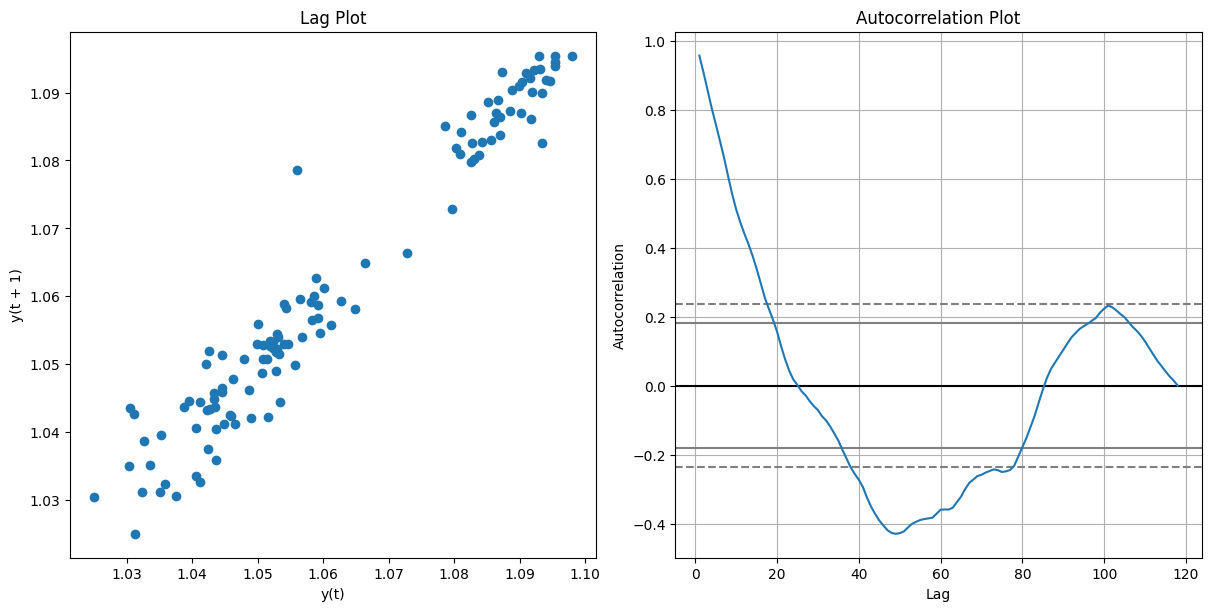

Coefficients: [0.03546008 0.96648491]
Test RMSE: 0.01727897148809157


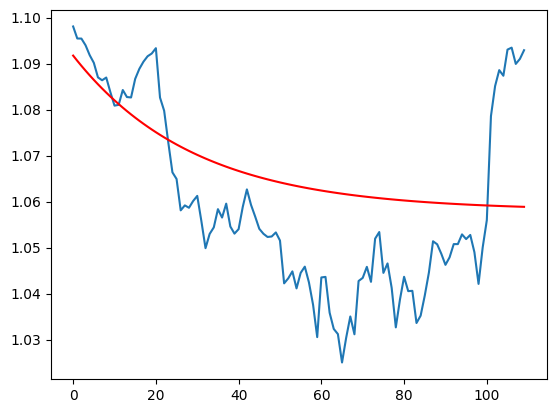

In [ ]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

# Create subplots
fig, (left, right) = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), layout="constrained"
)

series = data['High']

# Plot lag plot on the left axis
plt.sca(left)
lag_plot(series)
left.set_title("Lag Plot")  # Optional: Add a title to the left subplot

# Plot autocorrelation on the right axis
plt.sca(right)
pd.plotting.autocorrelation_plot(series, ax=right)
right.set_title("Autocorrelation Plot")  # Optional: Add a title to the right subplot

# Show the figure
plt.show()


""" Modelling """

# split into train and test sets, testing model on the past 7 days! 

values = pd.DataFrame(data['High'].values)
dataframe = pd.concat([values.shift(1), values], axis = 1)
dataframe.columns = ['t-1', 't+1']

X = dataframe.values
train, test = X[:len(X)-7], X[len(X)-7:]  # Use the first part for training, last 7 for testing

train, test = X[1:len(X)-7], X[1:len(X)-7]
X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

train = train[:, 0]  # Take only the first column as the endogenous variable (target)
test = test[:, 0]    # Same for the test dataset

# Train AutoRegression Model
model = AutoReg(train, lags=1)
model_fit = model.fit()
print(f'Coefficients: {model_fit.params}')

# Make Predictions
predictions = model_fit.predict(start = len(train), 
                                end=len(train) + len(test) - 1, 
                                dynamic = False)

# for i in range(len(predictions)):
#     print("-----------------------------------------------------")
#     print(f"predicted = {predictions[i]} \nexpected = {test[i]}")

rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse}')

# Plot the results 
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

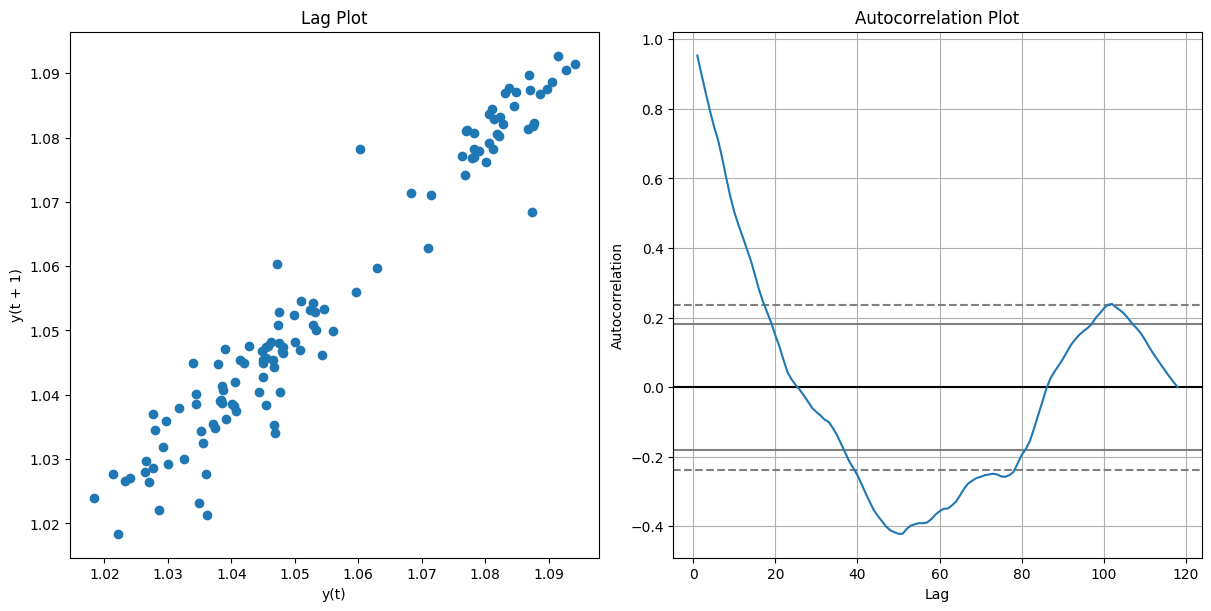

Coefficients: [0.04075206 0.96121431]
Test RMSE: 0.01685169340361358


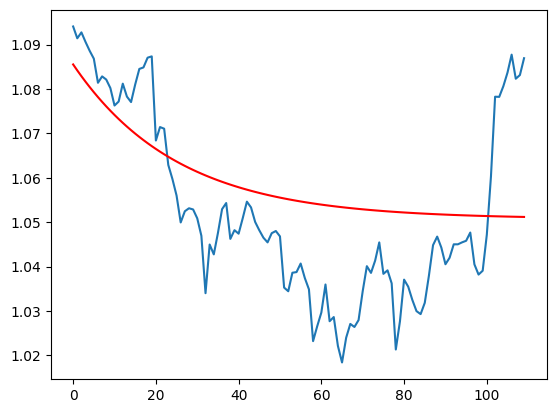

In [ ]:
# Create subplots
fig, (left, right) = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), layout="constrained"
)

series = data['Low']

# Plot lag plot on the left axis
plt.sca(left)
lag_plot(series)
left.set_title("Lag Plot")  # Optional: Add a title to the left subplot

# Plot autocorrelation on the right axis
plt.sca(right)
pd.plotting.autocorrelation_plot(series, ax=right)
right.set_title("Autocorrelation Plot")  # Optional: Add a title to the right subplot

# Show the figure
plt.show()

""" Modelling """

# split into train and test sets, testing model on the past 7 days! 

values = pd.DataFrame(data['Low'].values)
dataframe = pd.concat([values.shift(1), values], axis = 1)
dataframe.columns = ['t-1', 't+1']

X = dataframe.values
train, test = X[:len(X)-7], X[len(X)-7:]  # Use the first part for training, last 7 for testing

train, test = X[1:len(X)-7], X[1:len(X)-7]
X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

train = train[:, 0]  # Take only the first column as the endogenous variable (target)
test = test[:, 0]    # Same for the test dataset

# Train AutoRegression Model
model = AutoReg(train, lags=1)
model_fit = model.fit()
print(f'Coefficients: {model_fit.params}')

# Make Predictions
predictions = model_fit.predict(start = len(train), 
                                end=len(train) + len(test) - 1, 
                                dynamic = False)

# for i in range(len(predictions)):
#     print("-----------------------------------------------------")
#     print(f"predicted = {predictions[i]} \nexpected = {test[i]}")

rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse}')

# Plot the results 
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

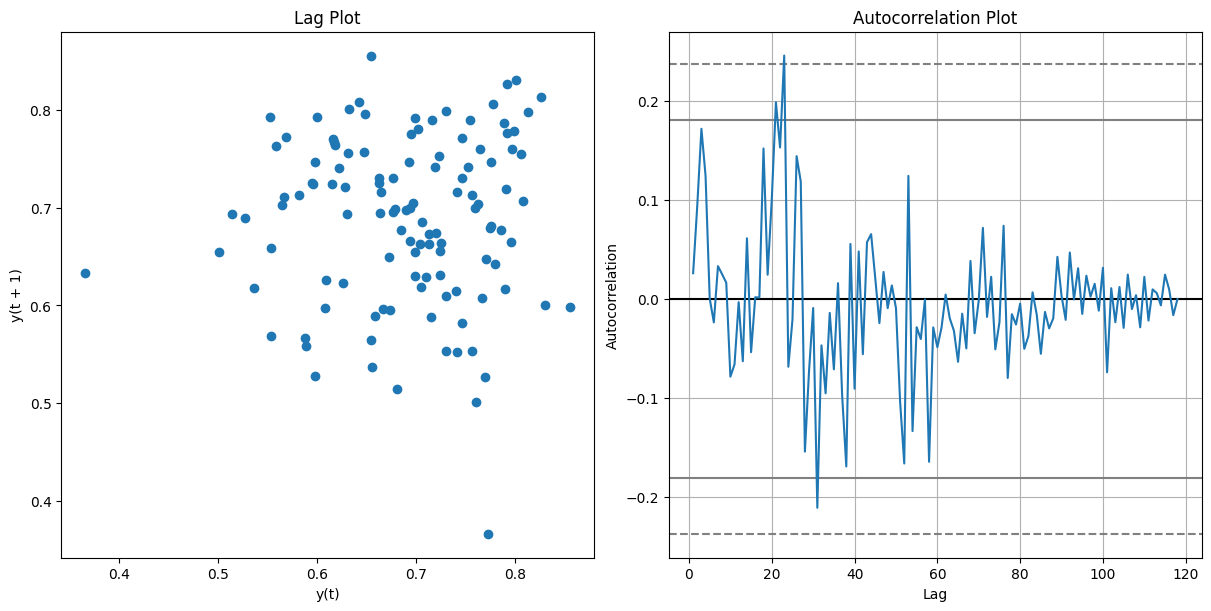

Coefficients: [ 0.23674235 -0.00202916  0.12728753  0.29303025  0.04209684 -0.0528974
 -0.11396701  0.13386151 -0.05732426 -0.03074099 -0.06018861 -0.03676116
  0.10667649 -0.05491748  0.04464499 -0.08061837 -0.09687683 -0.00999378
  0.1215288  -0.0668809   0.15124643  0.14202763  0.21754505  0.16280569
 -0.26394636 -0.26043049  0.04034191  0.26727194]
-----------------------------------------------------
predicted = 0.8290298650735737 
expected = 0.7759506702423096
-----------------------------------------------------
predicted = 0.6966712445571369 
expected = 0.6810092926025391
-----------------------------------------------------
predicted = 0.6248733243350633 
expected = 0.5146377682685852
-----------------------------------------------------
predicted = 0.7467165962501744 
expected = 0.6935147047042847
-----------------------------------------------------
predicted = 0.6842292679424368 
expected = 0.7466097474098206
-----------------------------------------------------
predicted =

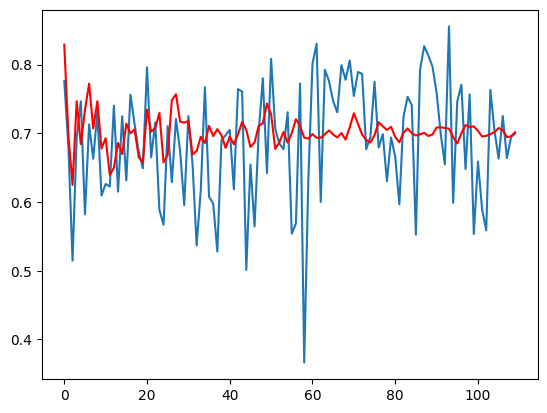

In [ ]:
# Create subplots
fig, (left, right) = plt.subplots(
    nrows=1, ncols=2, figsize=(12, 6), layout="constrained"
)

series = data['sentiment_polarity']

# Plot lag plot on the left axis
plt.sca(left)
lag_plot(series)
left.set_title("Lag Plot")  # Optional: Add a title to the left subplot

# Plot autocorrelation on the right axis
plt.sca(right)
pd.plotting.autocorrelation_plot(series, ax=right)
right.set_title("Autocorrelation Plot")  # Optional: Add a title to the right subplot

# Show the figure
plt.show()

""" Modelling """

values = pd.DataFrame(data['sentiment_polarity'].values)
dataframe = pd.concat([values.shift(1), values], axis = 1)
dataframe.columns = ['t-1', 't+1']

# split into train and test sets, testing model on the past 7 days! 
X = dataframe.values
train, test = X[:len(X)-7], X[len(X)-7:]  # Use the first part for training, last 7 for testing

train, test = X[1:len(X)-7], X[1:len(X)-7]
X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

train = train[:, 0]  # Take only the first column as the endogenous variable (target)
test = test[:, 0]    # Same for the test dataset

# Train AutoRegression Model
model = AutoReg(train, lags=27)
model_fit = model.fit()
print(f'Coefficients: {model_fit.params}')

# Make Predictions
predictions = model_fit.predict(start = len(train), 
                                end=len(train) + len(test) - 1, 
                                dynamic = False)

for i in range(len(predictions)):
    print("-----------------------------------------------------")
    print(f"predicted = {predictions[i]} \nexpected = {test[i]}")

rmse = np.sqrt(mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse}')

# Plot the results 
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

After modelling; we need to save our model to be used by our front-end to give our users the forecasts they need!

### Conducting Pearson Correlation Coefficients 

Ticker values, Aggregated by Day 

In [37]:
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis = 1)
dataframe.columns = ['t-1','t+1']
result = dataframe.corr()
print(f"The Pearson correlation coefficient for daily Forex value is: \n{result}")

The Pearson correlation coefficient for daily Forex value is: 
          t-1       t+1
t-1  1.000000  0.996379
t+1  0.996379  1.000000


Sentiment Analysis, Aggregated by Day

In [51]:
# display(series1)
values1 = pd.DataFrame(series1.values)
# display(values1)
dataframe1 = pd.concat([values1.shift(1), values1], axis = 1)
# display(dataframe1)
dataframe1.columns = ['t-1','t+1']
result1 = dataframe1.corr()
print(result1)

          t-1       t+1
t-1  1.000000  0.148592
t+1  0.148592  1.000000


Very weak correlation of sentiment analysis between sentiment polarity forecasting. This might be because let's say we're working with JPY=X (USD/JPY); it indicates the number of JPY to purchase 1 USD. 

So in relation; if we find an article talks positively about JPY, it should be a positive sentiment. And vice versa. 

If we find an article that tlks negatively about USD, it should be a positive sentiment. And vice versa.

# Modelling Using SARIMAX

NOTE: the following scenario only applies for when we have all the data we need (ie, the end of trading day). These predictions do not apply to intraday circumstances that exclude predictors such as `Close` and non-finalized `High` and `Low` data! 

The following is work referenced from https://medium.com/@tirthamutha/time-series-forecasting-using-sarima-in-python-8b75cd3366f2

In [11]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn.metrics 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.seasonal import seasonal_decompose 
import pandas as pd

from pandas.plotting import autocorrelation_plot

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

We need to show how the data moves overtime, and if we can truly forecast based on historical data

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

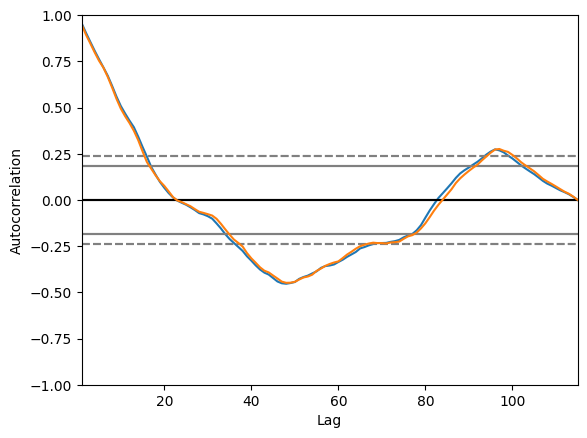

In [10]:
autocorrelation_plot(data['High'])
autocorrelation_plot(data['Low'])

We can observe that there is a seasonality component to our target variables. We observe a damped sinusoidal wave with one frequency occuring every ~100 lags. 

**Autocorrelation**

Lets find the correlation between a time series and the lagged version of itself (similar to the work we've done previously, but we'll graph it out this time! )

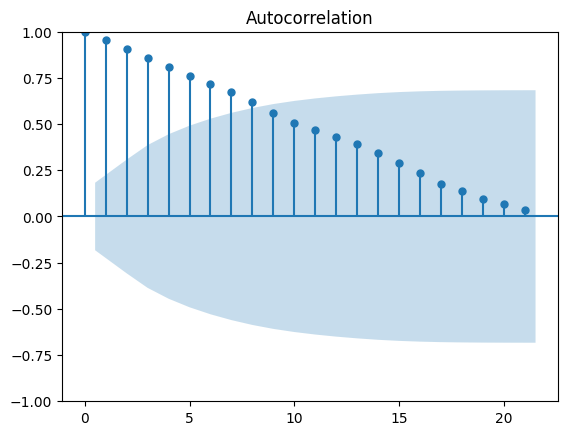

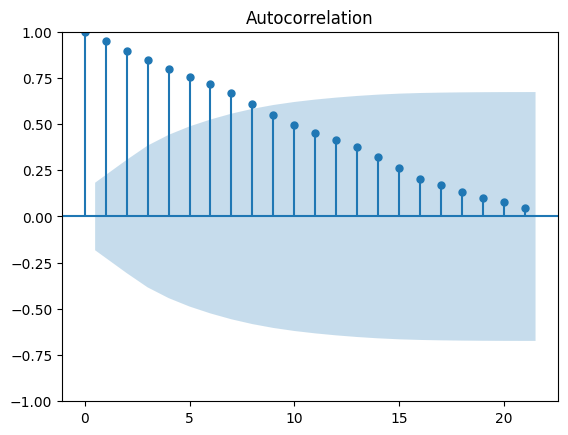

In [16]:
plot_acf(data['High'])
plt.show()

plot_acf(data['Low'])
plt.show()

Perfect! We can see that there is a strong autocorrelation with the data `High` and `Low`; but with a sharp decrease exponentially.  

**Partial-Autocorrelation**

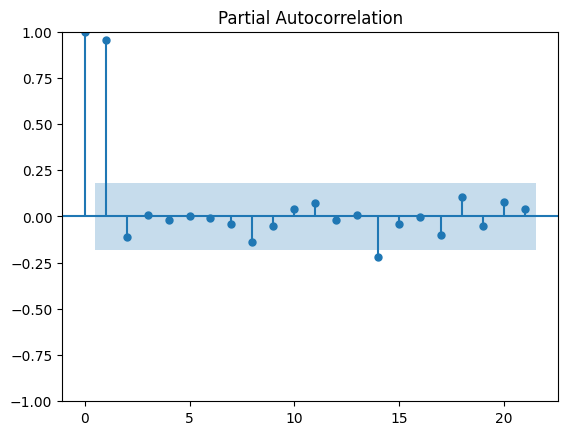

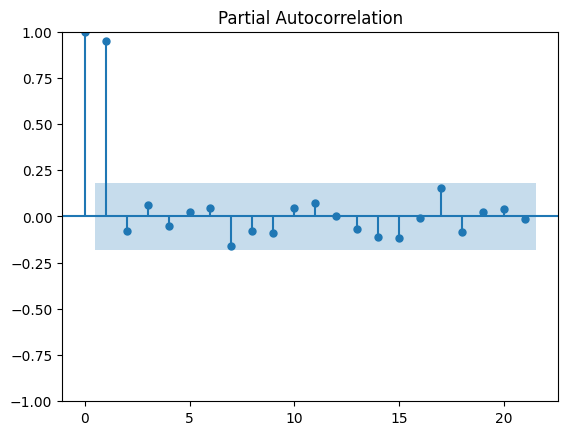

In [15]:
plot_pacf(data['High'])
plt.show()

plot_pacf(data['Low'])
plt.show()

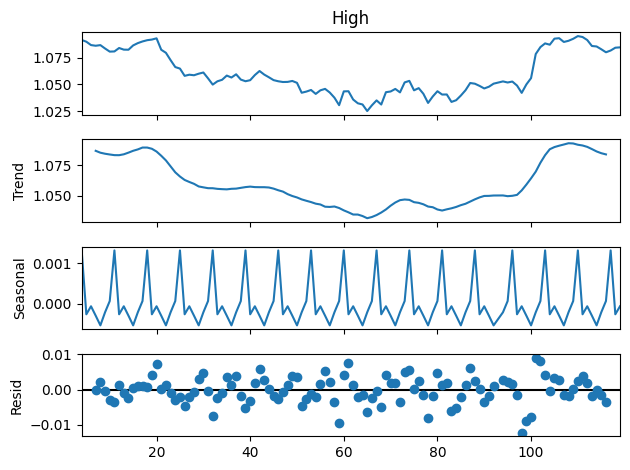

In [28]:
decomposition=seasonal_decompose(data['High'],model='additive',period=7)
decomposition.plot()
plt.show()

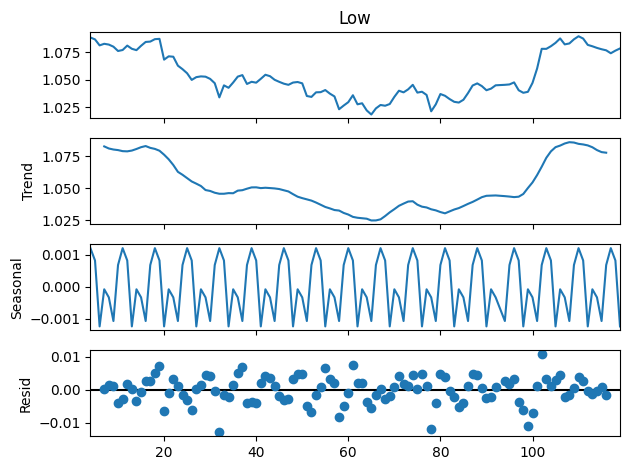

In [29]:
decomposition=seasonal_decompose(data['Low'],model='additive',period=7)
decomposition.plot()
plt.show()

**Augmented Dickey-Fuller Test**

In [46]:
print("--- High -----------------------------------")
data_diff=data['High'].diff(periods=3)
dftest = adfuller(data_diff.dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

print("--- Low -----------------------------------")
data_diff=data['Low'].diff(periods=3)
dftest = adfuller(data_diff.dropna(), autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

--- High -----------------------------------
1. ADF :  -3.746139426862434
2. P-Value :  0.0035090328029097075
3. Num Of Lags :  7
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 104
5. Critical Values :
	 1% :  -3.4948504603223145
	 5% :  -2.889758398668639
	 10% :  -2.5818220155325444
--- Low -----------------------------------
1. ADF :  -3.765428473732976
2. P-Value :  0.0032815071931352776
3. Num Of Lags :  7
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 104
5. Critical Values :
	 1% :  -3.4948504603223145
	 5% :  -2.889758398668639
	 10% :  -2.5818220155325444


Train-test split! 

In [158]:
from datetime import timedelta

# We'll make a psuedo train-test split 
data = pd.read_parquet("../data/modelling_dataset/EURUSD=X_modelling_dataset");

cutoff_date = datetime(month=3, day=20, year=2025)

train = data[data['date'] < cutoff_date]
test = data[data['date'] >= cutoff_date]

We have all the parameters we need! Lets build out SARIMAX model

In [159]:
# Fit SARIMAX with exogenous variables

predictors = train.drop(columns=['High','Low','date'])

sarima_exog = SARIMAX(
    train['High'], 
    order=(2, 3, 1), 
    seasonal_order=(1, 0, 1, 3), # Didn't plot the seasonal aspect... point to improve! 
    exog=predictors
)
model_fit = sarima_exog.fit()


c:\Users\sumag\Documents\MDSA\DATA 608\Project\env_fxTickerPredict\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\sumag\Documents\MDSA\DATA 608\Project\env_fxTickerPredict\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\sumag\Documents\MDSA\DATA 608\Project\env_fxTickerPredict\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [160]:
test

,date,sentiment_polarity,High,Low,Open,Close,sentiment_polarity_sma,High_sma,Low_sma,Open_sma,Close_sma
112,2025-03-20,0.741522,0.924411,0.915994,0.916590,0.916590,0.685055,0.938068,0.931219,0.935201,0.935201
113,2025-03-21,0.716170,0.925549,0.920887,0.921141,0.921141,0.688121,0.936493,0.929665,0.933638,0.933638
114,2025-03-24,0.789688,0.926784,0.921141,0.922961,0.922961,0.697670,0.935002,0.928231,0.932047,0.932047
115,2025-03-25,0.616771,0.927807,0.923378,0.925686,0.925686,0.691195,0.933578,0.926861,0.930531,0.930531
116,2025-03-26,0.769901,0.928712,0.925763,0.927042,0.927042,0.691149,0.932284,0.925640,0.929355,0.929355
117,2025-03-27,0.527181,0.931029,0.924317,0.931012,0.931012,0.685119,0.930774,0.924179,0.928237,0.928237
118,2025-03-28,0.546318,0.928867,0.922135,0.925892,0.925892,0.674603,0.929055,0.922302,0.926427,0.926427
119,2025-03-31,0.746794,0.927205,0.921837,0.923933,0.923933,0.684271,0.927291,0.920774,0.924605,0.924605
120,2025-04-01,0.714395,0.927730,0.923361,0.924385,0.924385,0.687049,0.925926,0.919589,0.923132,0.923132
121,2025-04-02,0.781711,0.927498,0.919760,0.926381,0.926381,0.696653,0.925143,0.919217,0.922388,0.922388


In [161]:
# Now we need to make forecasts of our predictors as well! 

def generate_future_predictors_sarimax(train): 
    forecasts = {}
    for predictor in data.drop(columns=['date','High','Low']).columns:
        # SARIMAX's parameters can be tuned to each predictor, but due to deadline of the project; we'll just keep it at the default settings
        sarima1=SARIMAX(train[predictor],
                        order=(1,1,1),
                        seasonal_order=(1,0,1,12))
        forecast=sarima1.fit().forecast(steps=8)
        forecasts[predictor] = forecast
    forecasts = pd.DataFrame(forecasts)
    return forecasts

future_predictors = generate_future_predictors_sarimax(train)


c:\Users\sumag\Documents\MDSA\DATA 608\Project\env_fxTickerPredict\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\sumag\Documents\MDSA\DATA 608\Project\env_fxTickerPredict\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

c:\Users\sumag\Documents\MDSA\DATA 608\Project\env_fxTickerPredict\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\sumag\Documents\MDSA\DATA 608\Project\env_fxTickerPredict\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be g

In [162]:
future_predictors

,sentiment_polarity,Open,Close,sentiment_polarity_sma,High_sma,Low_sma,Open_sma,Close_sma
107,0.691213,0.914171,0.914524,0.683774,0.937887,0.931146,0.935342,0.935342
108,0.678813,0.914002,0.914984,0.683835,0.935940,0.928871,0.933253,0.933253
109,0.677763,0.913826,0.915513,0.684207,0.933455,0.926479,0.931011,0.931012
110,0.697886,0.913846,0.915440,0.683911,0.930881,0.924098,0.928872,0.928873
111,0.694096,0.913774,0.915664,0.684206,0.928189,0.921664,0.926551,0.926553
112,0.693387,0.913777,0.915659,0.684574,0.925487,0.919217,0.924313,0.924316
113,0.701385,0.913707,0.915877,0.683688,0.922822,0.916939,0.922145,0.922148
114,0.688905,0.913737,0.915783,0.684349,0.920541,0.914899,0.920155,0.920158


In [173]:
forecast = model_fit.forecast(steps=8, exog=future_predictors)
print(forecast)

107    0.962961
108    1.038981
109    1.118388
110    1.104836
111    1.135477
112    1.131556
113    1.162735
114    1.150784
Name: predicted_mean, dtype: float64


c:\Users\sumag\Documents\MDSA\DATA 608\Project\env_fxTickerPredict\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\sumag\Documents\MDSA\DATA 608\Project\env_fxTickerPredict\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [188]:
# Join the tables together
dates = pd.Series(data=[cutoff_date + timedelta(days=i) for i in range(0,8)],name='date')
forecast1 = pd.concat([forecast.reset_index().drop(columns='index'), dates], axis=1)
display(forecast1)

,predicted_mean,date
0,0.962961,2025-03-20
1,1.038981,2025-03-21
2,1.118388,2025-03-22
3,1.104836,2025-03-23
4,1.135477,2025-03-24
5,1.131556,2025-03-25
6,1.162735,2025-03-26
7,1.150784,2025-03-27


,date,sentiment_polarity,High,Low,Open,Close,sentiment_polarity_sma,High_sma,Low_sma,Open_sma,Close_sma,yhat
0,2025-03-20,0.741522,0.924411,0.915994,0.916590,0.916590,0.685055,0.938068,0.931219,0.935201,0.935201,0.962961
1,2025-03-21,0.716170,0.925549,0.920887,0.921141,0.921141,0.688121,0.936493,0.929665,0.933638,0.933638,1.038981
2,2025-03-24,0.789688,0.926784,0.921141,0.922961,0.922961,0.697670,0.935002,0.928231,0.932047,0.932047,1.135477
3,2025-03-25,0.616771,0.927807,0.923378,0.925686,0.925686,0.691195,0.933578,0.926861,0.930531,0.930531,1.131556
4,2025-03-26,0.769901,0.928712,0.925763,0.927042,0.927042,0.691149,0.932284,0.925640,0.929355,0.929355,1.162735
5,2025-03-27,0.527181,0.931029,0.924317,0.931012,0.931012,0.685119,0.930774,0.924179,0.928237,0.928237,1.150784


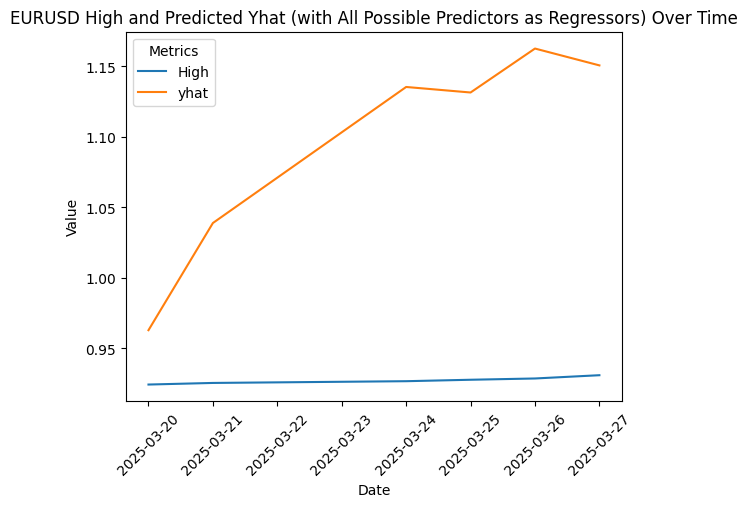

The RMSE is: 0.4286046492239469


In [196]:
merged = pd.merge(test, forecast1, how='inner', left_on='date', right_on='date').rename(columns={'predicted_mean': 'yhat'})
display(merged)

# Reshape the DataFrame to a long format for easy plotting with seaborn
plot_data = merged.melt(id_vars=['date'], value_vars=[target, 'yhat'], 
                        var_name='Metric', value_name='Value')

# Plot using seaborn
sns.lineplot(
    data=plot_data,
    x="date",
    y="Value",
    hue="Metric"  # Different colors for 'sentiment_polarity' and 'yhat'
)

# Optional: Add labels and a title
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("EURUSD High and Predicted Yhat (with All Possible Predictors as Regressors) Over Time")
plt.legend(title="Metrics")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

rmse = np.sqrt(root_mean_squared_error(merged['yhat'], merged[target]))
print(f"The RMSE is: {rmse}")

The ADF test is meant to check at which lag periods to we observe stationarity. We find that only for periods 3 or lower, do we get a significant ADF Test (Stationarity)! Therefore, it suggests that trends, patterns, or dependencies in the target data are effectively removed when differencing over a 3-day period.

# References: 

1. https://facebook.github.io/prophet/docs/quick_start.html#python-api (2025-03-22)
2. https://www.youtube.com/watch?v=ySiKZwoTX54 (2025-04-05)

Experiment